# Start of the project
---

## Dataset setup


In [350]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import albumentations as A
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from torch.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from glob import glob
from google.colab import drive
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, recall_score

In [377]:
drive.mount("/content/drive")

path = "/content/drive/MyDrive/Project_Robt_310/Dataset"
classes   = ["Clear", "Lump"]
splits    = ["Train", "Val", "Test"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [378]:
images  = {s: [] for s in splits}
labels = {s: [] for s in splits}

for s in splits:
    for i, c in enumerate(classes):
        paths = sorted(glob(f"{path}/{c}/{s}/*.png"))  # PNG only
        images[s]  += paths
        labels[s] += [i] * len(paths)

print(len(images["Train"]), "train images")


274 train images


## DataLoaders

In [379]:
IMG_SIZE = 224  # good for 500×500;
train_tfms = A.Compose([
A.Resize(IMG_SIZE, IMG_SIZE),
A.HorizontalFlip(p=0.5),


# Slight affine transformations for augmentation
A.Affine(
scale=(0.94, 1.06),
translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)},
rotate=(-6, 6),
p=0.4
),


# Speckle-like and light Gaussian blur
A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, p=0.3),
A.GaussianBlur(blur_limit=(3, 5), p=0.2),


A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
ToTensorV2()
])


# Validation transformations
val_tfms = A.Compose([
A.Resize(IMG_SIZE, IMG_SIZE),

A.HorizontalFlip(p=0.5),


# Slight affine transformations for augmentation
A.Affine(
scale=(0.94, 1.06),
translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)},
rotate=(-6, 6),
p=0.4
),


# Speckle-like and light Gaussian blur
A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, p=0.3),
A.GaussianBlur(blur_limit=(3, 5), p=0.2),
A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
ToTensorV2()
])


In [380]:
class Dataset(Dataset):
    def __init__(self, path, label, transform):
        self.path, self.label, self.transform = path, label, transform
    # store the files path, labels, and corresponding transformation

    def __len__(self): return len(self.path)
    # length of the dataset


    def __getitem__(self, i):
        img = Image.open(self.path[i]).convert("RGB") # open image file from
        # the disk
        x = self.transform(image=np.array(img))["image"] # preprocessing of the image
        # assign matrix of the image
        y = self.label[i] # assign a label
        return x, y

train_ds = Dataset(images["Train"], labels["Train"], train_tfms)
val_ds   = Dataset(images["Val"],   labels["Val"],   val_tfms)
test_ds  = Dataset(images["Test"],  labels["Test"],  val_tfms)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(274, 93, 92)

## Transformer Model

In [398]:
class Mlp(nn.Module):
    def __init__(self, feat, hid=None, out=None, act_layer=nn.SiLU, drop=0.): # we will try two activation layers: SiLu and GeLu
        super().__init__()
        out = out or feat # assign non-empty element
        hid = hid or feat # assign non-empty element
        self.fc1 = nn.Linear(feat, hid) # linear projection to higher dimension
        self.act = act_layer() # simple use of activation function
        self.fc2 = nn.Linear(hid, out) # linear projection to lower dimension (restore the dimension of the input)
        self.drop = nn.Dropout(drop) # Regularization method to prevent overfitting

    def forward(self, x): # execute the path
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def window_partition(x, wind_size):
    B, H, W, C = x.shape # get the input shape
    x = x.view(B, H // wind_size, wind_size, W // wind_size, wind_size, C) # window position & position in the window
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, wind_size, wind_size, C)
    # change the positions between 2 and 3, so windows will be together, and
    # window positions too.
    return windows

def window_reverse(windows, wind_size, H, W):
    B = int(windows.shape[0] / (H * W / wind_size / wind_size)) # calculating the original size
    x = windows.view(B, H // wind_size, W // wind_size, wind_size, wind_size, -1)
    #  fold the structure of the windows back to the grid
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1) # permute and merge back to restore
    return x

class WindowAttention(nn.Module):
    def __init__(self, d, wind_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.d = d
        self.wind_size = wind_size
        self.num_heads = num_heads
        head_d = d // num_heads
        self.scale = qk_scale or head_d ** -0.5 # scaling factor for the dot product
        # mathematical explanation in the report


        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * wind_size[0] - 1) * (2 * wind_size[1] - 1), num_heads)
        )  # Relative position bias table (every possible spatial relation between
        # two pixels in a window)

        # descartes coordinate system for window
        coords_h = torch.arange(self.wind_size[0])
        coords_w = torch.arange(self.wind_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))

        # difference between every pixel pair (A=(0,0), B=(2,1) => rel.coor. = (-2,-1))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.wind_size[0] - 1  # shift to start from 0 (python cannot handle negative signs in lists)
        relative_coords[:, :, 1] += self.wind_size[1] - 1

        relative_coords[:, :, 0] *= 2 * self.wind_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        # change from XY grid to X grid (2D into 1D)


        # setup the attention mechanishm (Just like for the MLP)
        self.qkv = nn.Linear(d, d * 3, bias=qkv_bias) # (star)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(d, d)
        self.proj_drop = nn.Dropout(proj_drop)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # projects x to the 3 times Dimensions (star)
        q, k, v = qkv[0], qkv[1], qkv[2] # get the query, key, and value

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1)) # dot product of query and key

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.wind_size[0] * self.wind_size[1], self.wind_size[0] * self.wind_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        # get the value from bias table
        attn = attn + relative_position_bias.unsqueeze(0) # adds bias to the attention score

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
            # sets attention between non-adjacent pixels to zero
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C) # dot product of attention score with value
        x = self.proj(x)
        x = self.proj_drop(x)
        return x # return the projection layer

# Start of the open Source-Code Swin Trasnformer Code
class SwinTransformerBlock(nn.Module):

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, wind_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(feat=dim, hid=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, attn_mask):
        H, W = self.H, self.W
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)


        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

            x_windows = window_partition(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = window_partition(shifted_x, self.window_size)

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)


        attn_windows = self.attn(x_windows, mask=attn_mask)


        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C


        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)


        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

class PatchMerging(nn.Module):
    """
    Patch Merging Layer.
    """
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """
        x: B, H*W, C
        """
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)


        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)

        x = self.norm(x)
        x = self.reduction(x)

        return x

class BasicLayer(nn.Module):
    """
    A basic Swin Transformer layer for one stage.
    """
    def __init__(self, dim, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.shift_size = window_size // 2

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim, num_heads=num_heads, window_size=window_size,
                shift_size=0 if (i % 2 == 0) else self.shift_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop, attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer
            )
            for i in range(depth)])

        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def create_mask(self, H, W):
        img_mask = torch.zeros((1, H, W, 1))
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x, H, W):
        attn_mask = self.create_mask(H, W).to(x.device)

        for blk in self.blocks:
            blk.H, blk.W = H, W
            if blk.shift_size > 0:
                x = blk(x, attn_mask)
            else:
                x = blk(x, attn_mask=None)

        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = (H + 1) // 2, (W + 1) // 2

        return x, H, W

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x

class SwinTransformer(nn.Module):
    """
    Swin Transformer Main Class
    """
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio


        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        self.patches_resolution = self.patch_embed.patches_resolution

        self.pos_drop = nn.Dropout(p=drop_rate)


        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None
            )
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        H, W = self.patches_resolution

        for layer in self.layers:
            x, H, W = layer(x, H, W)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

In [416]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=2,
    embed_dim=36,
    depths=[2, 2, 6, 3],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    drop_path_rate=0.15
).to(device)

In [417]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4909880


In [418]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.2)

scaler = torch.amp.GradScaler('cuda')

best_f1 = 0.0
best_model_path = "best_swin_model_f1.pt"

In [ ]:
num_epochs = 15

for epoch in range(1, num_epochs + 1):

    model.train()
    train_loss_sum = 0.0
    train_total = 0

    train_preds = []
    train_targets = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda'):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss_sum += loss.item() * xb.size(0)
        train_total += yb.size(0)

        _, preds = torch.max(logits, 1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(yb.cpu().numpy())

    train_avg_loss = train_loss_sum / train_total
    train_epoch_f1 = f1_score(train_targets, train_preds, average='weighted') #5*(accuracy_score(train_targets, train_preds)*recall_score(train_targets, train_preds)) / (accuracy_score(train_targets, train_preds) + 4*recall_score(train_targets, train_preds))

    model.eval()
    val_loss_sum = 0.0
    val_total = 0

    val_preds = []
    val_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            with torch.amp.autocast('cuda'):
                logits = model(xb)
                loss = criterion(logits, yb)

            val_loss_sum += loss.item() * xb.size(0)
            val_total += yb.size(0)

            _, preds = torch.max(logits, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(yb.cpu().numpy())

    val_avg_loss = val_loss_sum / val_total
    val_epoch_f1 = f1_score(val_targets, val_preds, average='weighted') #5*(accuracy_score(val_targets, val_preds)*recall_score(val_targets, val_preds)) / (accuracy_score(val_targets, val_preds) + 4*recall_score(val_targets, val_preds))

    print(f"Epoch {epoch:02d} | Train Loss: {train_avg_loss:.4f} F1: {train_epoch_f1:.4f} | Val Loss: {val_avg_loss:.4f} F1: {val_epoch_f1:.4f}")

    if val_epoch_f1 > best_f1:
        best_f1 = val_epoch_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"  --> Bim Bim! New Best model bro!")

Epoch 01 | Train Loss: 0.7388 F1: 0.5399 | Val Loss: 0.6852 F1: 0.6080
  --> Bim Bim! New Best model bro!
Epoch 02 | Train Loss: 0.6898 F1: 0.6050 | Val Loss: 0.7369 F1: 0.2802
Epoch 03 | Train Loss: 0.6956 F1: 0.6337 | Val Loss: 0.8510 F1: 0.2802
Epoch 04 | Train Loss: 0.6949 F1: 0.5749 | Val Loss: 0.6733 F1: 0.6369
  --> Bim Bim! New Best model bro!
Epoch 05 | Train Loss: 0.6777 F1: 0.6031 | Val Loss: 0.6291 F1: 0.6136
Epoch 06 | Train Loss: 0.6923 F1: 0.6234 | Val Loss: 0.7178 F1: 0.5373
Epoch 07 | Train Loss: 0.6866 F1: 0.6264 | Val Loss: 0.6955 F1: 0.5794
Epoch 08 | Train Loss: 0.6651 F1: 0.5957 | Val Loss: 0.6267 F1: 0.6017
Epoch 09 | Train Loss: 0.6709 F1: 0.6631 | Val Loss: 0.6886 F1: 0.6204
Epoch 10 | Train Loss: 0.6727 F1: 0.6440 | Val Loss: 0.7986 F1: 0.2969
Epoch 11 | Train Loss: 0.6413 F1: 0.6746 | Val Loss: 0.6379 F1: 0.6519
  --> Bim Bim! New Best model bro!
Epoch 12 | Train Loss: 0.6442 F1: 0.7111 | Val Loss: 0.6400 F1: 0.5900
Epoch 13 | Train Loss: 0.6368 F1: 0.6667 | 

## Test evaluation

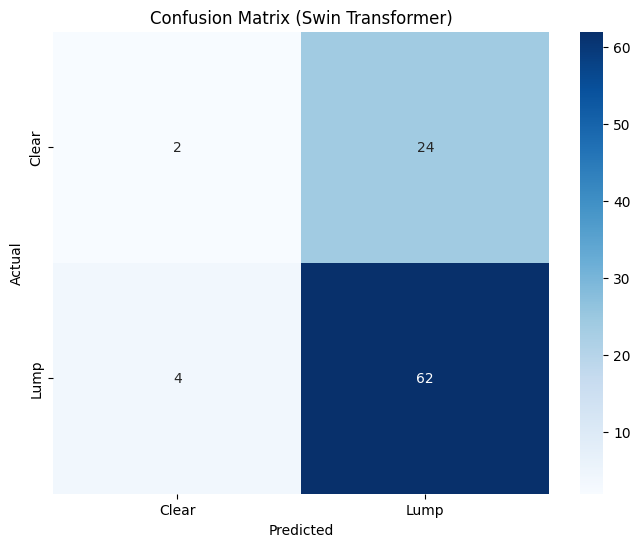

In [415]:
from google.colab import files
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        _, preds = torch.max(logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
f1_test = f1_score(all_labels, all_preds,average='weighted')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Swin Transformer)')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

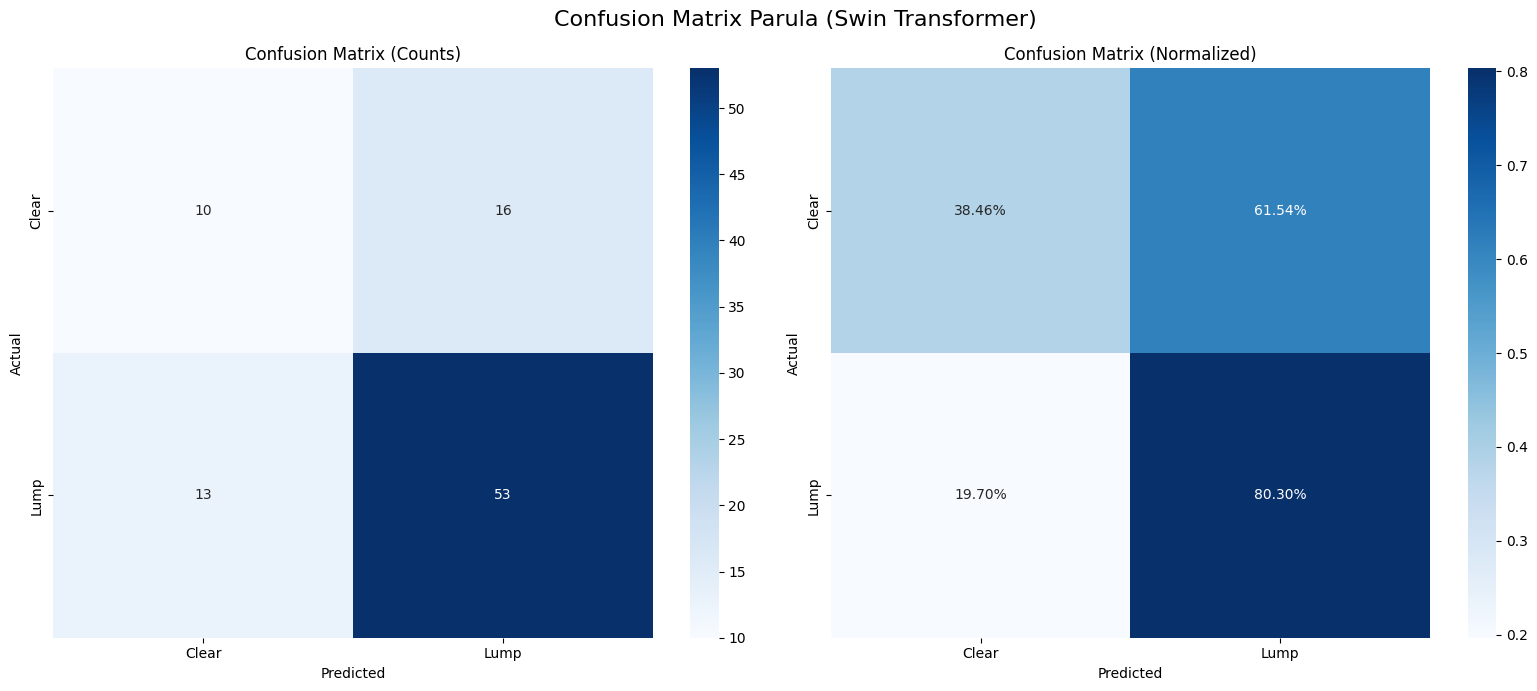

In [376]:
from google.colab import files
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        _, preds = torch.max(logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix (Counts)')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.suptitle(f'Confusion Matrix(Swin Transformer)', fontsize=16)
plt.tight_layout()

plt.savefig("confusion_SWIN.png", dpi=350)
files.download("confusion_SWIN.png")
plt.show()